In [2]:
import matplotlib.pyplot as plt
from helpers import *
torch.set_printoptions(precision=2,sci_mode=False, linewidth=200)

## Data Model

In [4]:
n_points = 100
n_features = 5
n_train_sets = 5
n_test_trials = 10
print("n_points:", n_points)
print("n_features:", n_features)

# Fix the variance to 1/n_features.
sig_sq = 1.0/n_features

# dist_sd_ratio = K, where norm(u-v) = K*sigma.
dist_sd_ratios = np.logspace(-1, .05 + .5*np.log(np.log(n_points)), num=20)
# dist_sd_ratios = np.linspace(1./10., 1.2*np.log(n_points), num=100)
data_model = {}
p = .5
q = .1
for K in dist_sd_ratios:
    data_model[K] = XCSBM(n_points, n_features, K, sig_sq, p, q)

n_points: 100
n_features: 5


## Training

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

loss_fn = nn.BCELoss()
epochs = 1000

# Learning models.
learners = {
    'mlp': {}, # 2 layer MLPs
    'gcn2l01': {}, # 2 layer GCN with 1 GC at layer 2
    'gcn2l02': {}, # 2 layer GCN with 2 GCs at layer 2
    'gcn3l010': {}, # 3 layer GCN with 1 GC at layer 2
    'gcn3l001': {}, # 3 layer GCN with 1 GC at layer 3
    'gcn3l020': {}, # 3 layer GCN with 2 GCs at layer 2
    'gcn3l002': {}, # 3 layer GCN with 2 GCs at layer 3
    'gcn3l011': {} # 3 layer GCN with 1 GC each at layers 2 and 3
}

train_acc = {}
train_loss = {}

# Fix network architectures for the networks.
channels_2l = [[n_features, 4], [4, 1]]
channels_3l = [[n_features, 4, 2], [4, 2, 1]]

for K in dist_sd_ratios:
    learners['mlp'][K] = MLP(n_layers=2, n_features=n_features, channels=channels_2l)
    learners['gcn2l01'][K] = GCN(n_layers=2, n_features=n_features, convolutions=[0, 1], channels=channels_2l)
    learners['gcn2l02'][K] = GCN(n_layers=2, n_features=n_features, convolutions=[0, 2], channels=channels_2l)
    learners['gcn3l010'][K] = GCN(n_layers=3, n_features=n_features, convolutions=[0, 1, 0], channels=channels_3l)
    learners['gcn3l001'][K] = GCN(n_layers=3, n_features=n_features, convolutions=[0, 0, 1], channels=channels_3l)
    learners['gcn3l020'][K] = GCN(n_layers=3, n_features=n_features, convolutions=[0, 2, 0], channels=channels_3l)
    learners['gcn3l002'][K] = GCN(n_layers=3, n_features=n_features, convolutions=[0, 0, 2], channels=channels_3l)
    learners['gcn3l011'][K] = GCN(n_layers=3, n_features=n_features, convolutions=[0, 1, 1], channels=channels_3l)

print('Training', len(dist_sd_ratios), 'MLP and GCN models...')

for model_type in learners:
    train_acc[model_type] = []
    train_loss[model_type] = []
    for (j, K) in enumerate(dist_sd_ratios):
        print('\rTraining', j+1, '/', len(dist_sd_ratios), model_type, 'models...', end='')
        learner = learners[model_type][K].to(device)
        data = data_model[K].generate_data().to(device)
        set_params(learner, data_model[K], n_layers=learner.n_layers, device=device)
        train_model(learner, data, loss_fn, epochs=epochs)
        learner.eval()
        out = learner(data)
        loss = loss_fn(out, data.y.float())
        acc = accuracy(out, data.y)
        train_acc[model_type].append(acc)
        train_loss[model_type].append(loss.item())

print('\nTraining complete.')

Using device: cpu
Training 20 MLP and GCN models...
Training 20 / 20 gcn3l011 models...
Training complete.


In [ ]:
# Save data-models and learners to disk to avoid retraining.

## Evaluation

In [6]:
test_acc = {}
test_acc_std = {}
test_loss = {}
test_loss_std = {}

for model_type in learners:
    test_acc[model_type] = []
    test_acc_std[model_type] = []
    test_loss[model_type] = []
    test_loss_std[model_type] = []
    
    for (j, K) in enumerate(dist_sd_ratios):
        print('\rEvaluating', j+1, '/', len(dist_sd_ratios), model_type, 'models...', end='')
        loss_list = torch.zeros(n_test_trials)
        acc_list = torch.zeros(n_test_trials)
        learner = learners[model_type][K].to(device)
        for t in range(n_test_trials):
            data = data_model[K].generate_data().to(device)
            pred = learner(data)
            acc_list[t] = accuracy(pred, data.y)
            loss_list[t] = loss_fn(pred, data.y.float()).item()
        
        test_acc[model_type].append(acc_list.mean().item())
        test_acc_std[model_type].append(acc_list.std().item())
        test_loss[model_type].append(loss_list.mean().item())
        test_loss_std[model_type].append(loss_list.std().item())

print('\nEvaluation complete.')

Evaluating 20 / 20 gcn3l011 models...
Evaluation complete.


## Plotting helpers

In [7]:
line_wd = 1 # line width for plots.
marker_sz = 2 # marker size for plots.
labels = {
    'mlp': 'MLP',
    'gcn2l01': 'GCN 2 layers 1 conv at layer 2',
    # 'gcn2l02': 'GCN 2 layers 2 convs at layer 2',
    'gcn3l010': 'GCN 3 layers 1 conv at layer 2',
    'gcn3l001': 'GCN 3 layers 1 conv at layer 3',
    # 'gcn3l020': 'GCN 3 layers 2 convs at layer 2',
    # 'gcn3l002': 'GCN 3 layers 2 convs at layer 3',
    # 'gcn3l011': 'GCN 3 layers 1 conv each at layer 2 and 3'
}

def plot_with_std(ax, x, y, yerr, label):
    y = np.asarray(y)
    yerr = np.asarray(yerr)
    ax.plot(x, y, linewidth=line_wd, linestyle= '-', marker='.', markersize=marker_sz, label=label)
    ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)

## Plot loss

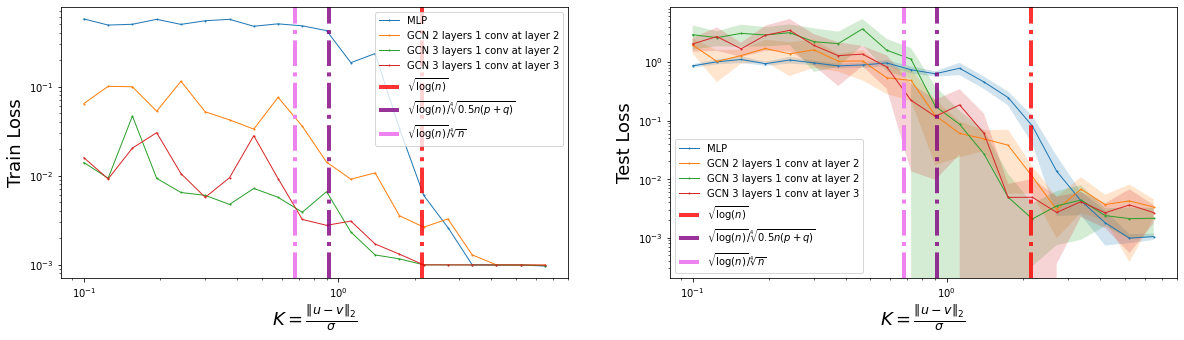

In [9]:
fig = plt.figure(figsize=(20,5), facecolor=[1,1,1])
gs = fig.add_gridspec(1, 2, hspace=0)
axs = gs.subplots()
for i in range(2):
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')

axs[0].set_ylabel(r'Train Loss', fontsize=18)
axs[1].set_ylabel(r'Test Loss', fontsize=18)
    
# Plot the training and test losses for each model.
for model_type in labels:
    axs[0].plot(dist_sd_ratios, train_loss[model_type], linewidth=line_wd, linestyle= '-', marker='.', markersize=marker_sz, label=labels[model_type])
    plot_with_std(axs[1], dist_sd_ratios, test_loss[model_type], test_loss_std[model_type], labels[model_type])

for i in range(2):
    axs[i].axvline(x=np.sqrt(np.log(n_points)), color='red', linewidth=4, linestyle='-.', alpha=.8, label=r'$\sqrt{\log(n)}$')
    axs[i].axvline(
        x=np.sqrt(np.log(n_points)/np.sqrt(.5*n_points*(p+q))),
        color='purple', linewidth=4, linestyle='-.', alpha=.8,
        label=r'$\sqrt{\log(n)}/\sqrt[4]{0.5n(p+q)}$')
    axs[i].axvline(
        x=np.sqrt(np.log(n_points)/np.sqrt(n_points)),
        color='violet', linewidth=4, linestyle='-.', alpha=1,
        label=r'$\sqrt{\log(n)}/\sqrt[4]{n}$')
    axs[i].set_xlabel(r'$K = \frac{\Vert u-v \Vert_2}{\sigma}$', fontsize=18)
    axs[i].legend()
fig.savefig("../../figures/synthetic_data_mlp_vs_gcn_loss.pdf", dpi=400, bbox_inches='tight')

## Plot accuracy

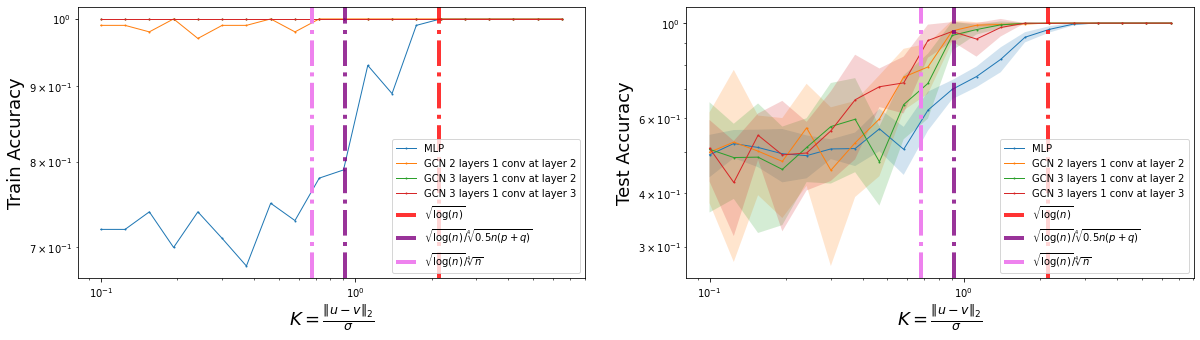

In [12]:
fig = plt.figure(figsize=(20,5), facecolor=[1,1,1])
gs = fig.add_gridspec(1, 2, hspace=0)
axs = gs.subplots()
for i in range(2):
    axs[i].set_xscale('log')

axs[0].set_ylabel(r'Train Accuracy', fontsize=18)
axs[1].set_ylabel(r'Test Accuracy', fontsize=18)
    
# Plot the training and test losses for each model.
for model_type in labels:
    axs[0].plot(dist_sd_ratios, train_acc[model_type], linewidth=line_wd, linestyle= '-', marker='.', markersize=marker_sz, label=labels[model_type])
    plot_with_std(axs[1], dist_sd_ratios, test_acc[model_type], test_acc_std[model_type], labels[model_type])

for i in range(2):
    axs[i].axvline(x=np.sqrt(np.log(n_points)), color='red', linewidth=4, linestyle='-.', alpha=.8, label=r'$\sqrt{\log(n)}$')
    axs[i].axvline(
        x=np.sqrt(np.log(n_points)/np.sqrt(.5*n_points*(p+q))),
        color='purple', linewidth=4, linestyle='-.', alpha=.8,
        label=r'$\sqrt{\log(n)}/\sqrt[4]{0.5n(p+q)}$')
    axs[i].axvline(
        x=np.sqrt(np.log(n_points)/np.sqrt(n_points)),
        color='violet', linewidth=4, linestyle='-.', alpha=1,
        label=r'$\sqrt{\log(n)}/\sqrt[4]{n}$')
    axs[i].set_xlabel(r'$K = \frac{\Vert u-v \Vert_2}{\sigma}$', fontsize=18)
    axs[i].legend()
fig.savefig("../../figures/synthetic_data_mlp_vs_gcn_loss.pdf", dpi=400, bbox_inches='tight')